In [1]:
pip install kagglehub

In [2]:
# 1. Load Dataset from Kaggle
import kagglehub
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Download the dataset from Kaggle
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
print("Dataset path:", path)
print("Folders:", os.listdir(path))


Dataset path: /kaggle/input/rockpaperscissors
Folders: ['paper', 'rock', 'rps-cv-images', 'README_rpc-cv-images.txt', 'scissors']


In [3]:
# 2. Explore Dataset Structure

base_path = path  # base dataset path
classes = ["rock", "paper", "scissors"]

# Count number of images per class
for cls in classes:
    images = glob.glob(os.path.join(base_path, cls, "*.png"))
    print(f"{cls}: {len(images)} images")

# Also check rps-cv-images (for test set)
subfolders = os.listdir(os.path.join(base_path, "rps-cv-images"))
print("\nFolders inside rps-cv-images:", subfolders)

rock: 726 images
paper: 712 images
scissors: 750 images

Folders inside rps-cv-images: ['paper', 'rock', 'README_rpc-cv-images.txt', 'scissors']


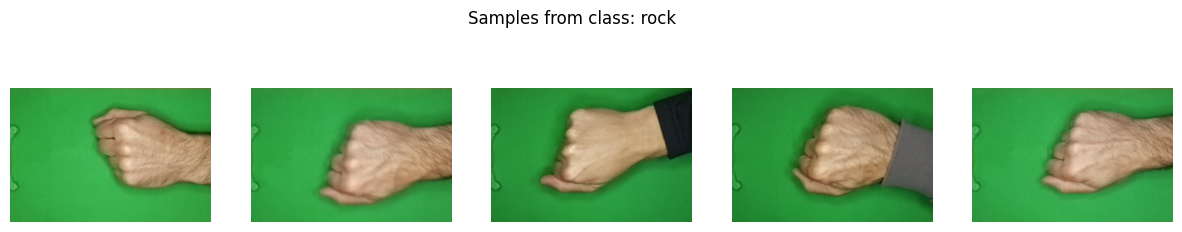

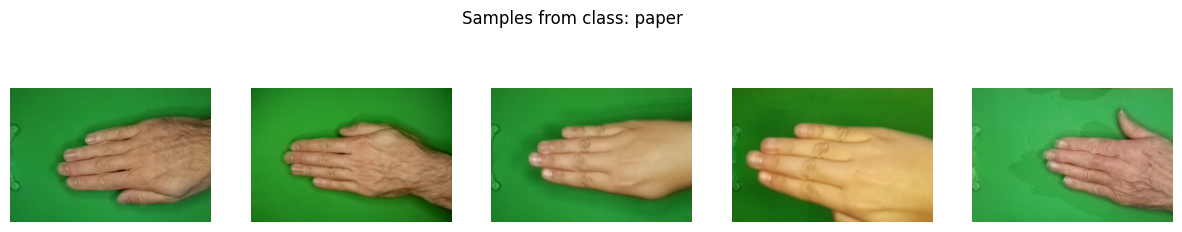

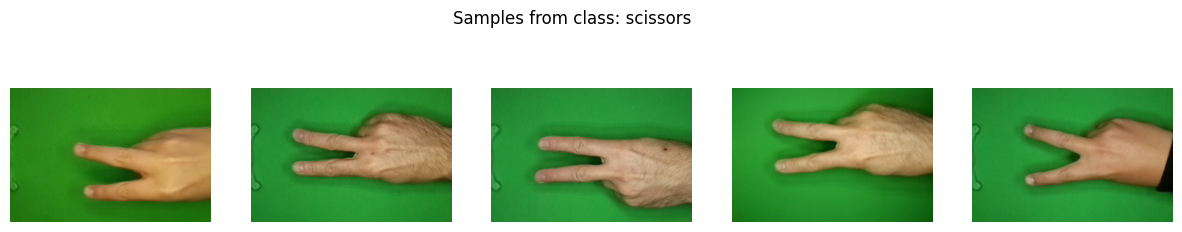

In [4]:
# 3. Show Sample Images
def show_samples(class_name, n=5):
    img_paths = glob.glob(os.path.join(base_path, class_name, "*.png"))[:n]
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(img_paths):
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Samples from class: {class_name}")
    plt.show()

for cls in classes:
    show_samples(cls, n=5)


In [5]:
# 4. Manual Data Loading + Preprocessing
# Parameters
img_size = (150, 150)

X = []
y = []

# Load all images into arrays manually
for idx, cls in enumerate(classes):
    img_paths = glob.glob(os.path.join(base_path, cls, "*.png"))
    for img_path in img_paths:
        # Load image and resize
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0  # normalize to [0,1]
        X.append(img_array)
        y.append(idx)  # class index

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

# One-hot encode labels
y = to_categorical(y, num_classes=len(classes))


Dataset shape: (2188, 150, 150, 3)
Labels shape: (2188,)


In [6]:
# 5. Manual Train/Validation Split
def manual_train_val_split(X, y, val_ratio=0.2, seed=42):
    """
    Split dataset manually into training and validation sets.
    """
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    val_size = int(len(X) * val_ratio)

    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = manual_train_val_split(X, y, val_ratio=0.2)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Training set: (1751, 150, 150, 3) (1751, 3)
Validation set: (437, 150, 150, 3) (437, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple CNN (Baseline)
model1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model1.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,328,067 (20.32 MB)

 Trainable params: 5,328,067 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train Model 1
history1 = model1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4399 - loss: 1.5974 - val_accuracy: 0.7803 - val_loss: 0.5223
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8419 - loss: 0.4982 - val_accuracy: 0.9130 - val_loss: 0.2749
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9035 - loss: 0.2959 - val_accuracy: 0.9588 - val_loss: 0.1503
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9574 - loss: 0.1338 - val_accuracy: 0.9634 - val_loss: 0.1204
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9765 - loss: 0.0878 - val_accuracy: 0.9703 - val_loss: 0.1034
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9804 - loss: 0.0676 - val_accuracy: 0.9565 - val_loss: 0.1331
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9921 - loss: 0.0289 - val_accuracy: 0.9611 - val_loss: 0.0838
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9938 - loss: 0.0255 - val_accuracy: 0.9588 - 

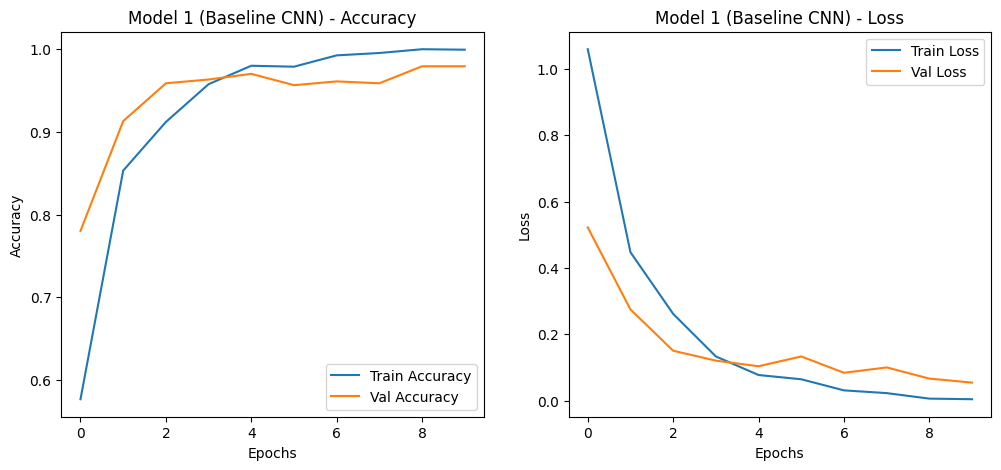

In [9]:
import matplotlib.pyplot as plt

def plot_history(history, title="Training History"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history1, title="Model 1 (Baseline CNN)")


In [10]:
# Model 2: Deeper CNN with Dropout
model2 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),   # Dropout to reduce overfitting
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

# Train model 2
history2 = model2.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5034 - loss: 1.0034 - val_accuracy: 0.8444 - val_loss: 0.4169
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8179 - loss: 0.4795 - val_accuracy: 0.9382 - val_loss: 0.1507
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8923 - loss: 0.2655 - val_accuracy: 0.9519 - val_loss: 0.1368
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9465 - loss: 0.1672 - val_accuracy: 0.9680 - val_loss: 0.0846
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9538 - loss: 0.1421 - val_accuracy: 0.9634 - val_loss: 0.0774
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9691 - loss: 0.1003 - val_accuracy: 0.9565 - val_loss: 0.1546
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9585 - loss: 0.1077 - val_accuracy: 0.9588 - val_loss: 0.1089
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9625 - loss: 0.0706 - val_accuracy: 0.9657 - 

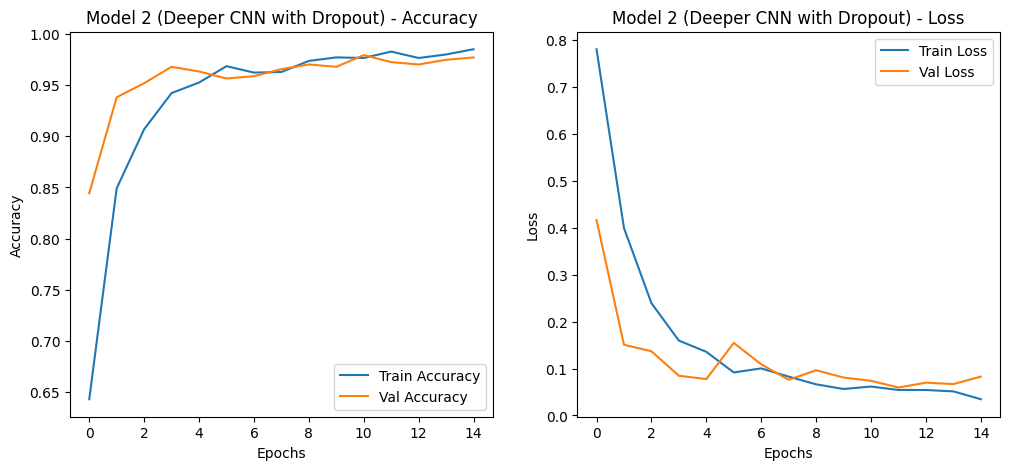

In [12]:
# Plot training curves
plot_history(history2, title="Model 2 (Deeper CNN with Dropout)")


In [13]:
# Model 3: Deep CNN with Batch Normalization and Dropout
model3 = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 4
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout again
    layers.Dense(3, activation='softmax')
])

# Compile model
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,602,627 (13.74 MB)

 Trainable params: 3,601,667 (13.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:

# Train model 3
history3 = model3.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.7228 - loss: 2.7987 - val_accuracy: 0.3455 - val_loss: 12.6745
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9535 - loss: 0.2399 - val_accuracy: 0.3455 - val_loss: 21.4923
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9576 - loss: 0.2059 - val_accuracy: 0.3455 - val_loss: 20.7746
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9724 - loss: 0.1414 - val_accuracy: 0.3455 - val_loss: 25.3168
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9847 - loss: 0.0857 - val_accuracy: 0.3455 - val_loss: 21.8059
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9776 - loss: 0.1031 - val_accuracy: 0.3455 - val_loss: 16.6052
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9802 - loss: 0.0731 - val_accuracy: 0.4302 - val_loss: 8.0732
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9768 - loss: 0.1490 - val_accuracy: 0.

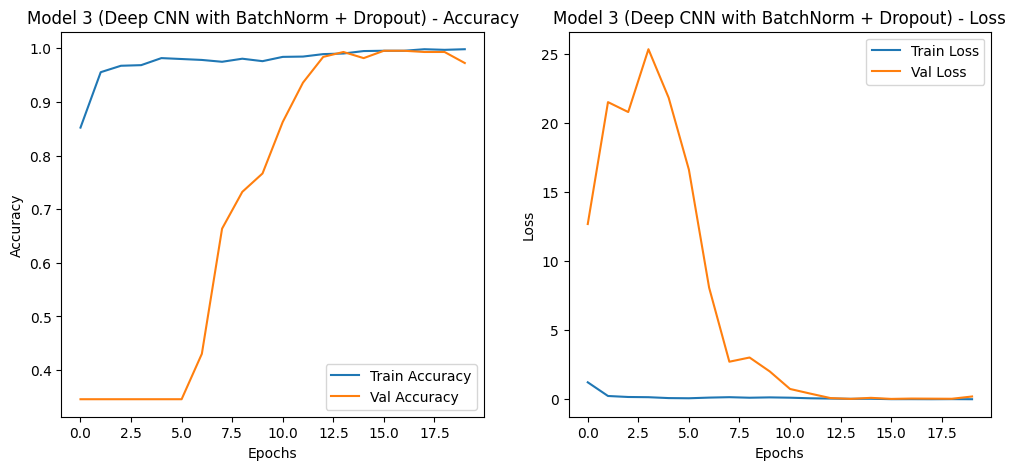

In [15]:

# Plot training curves
plot_history(history3, title="Model 3 (Deep CNN with BatchNorm + Dropout)")


In [16]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to test set (rps-cv-images)
test_path = os.path.join(base_path, "rps-cv-images")
classes = ["rock", "paper", "scissors"]

X_test, y_test = [], []

# Load and preprocess test images manually
for idx, cls in enumerate(classes):
    class_dir = os.path.join(test_path, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=img_size)   # resize
        img_array = img_to_array(img) / 255.0            # normalize
        X_test.append(img_array)
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test set:", X_test.shape, y_test.shape)


Test set: (2188, 150, 150, 3) (2188,)


In [17]:
# Evaluate model on manual test set
test_loss, test_acc = model3.evaluate(X_test, tf.keras.utils.to_categorical(y_test, num_classes=3), verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9904 - loss: 0.0659
Test Accuracy: 0.9858, Test Loss: 0.0937


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


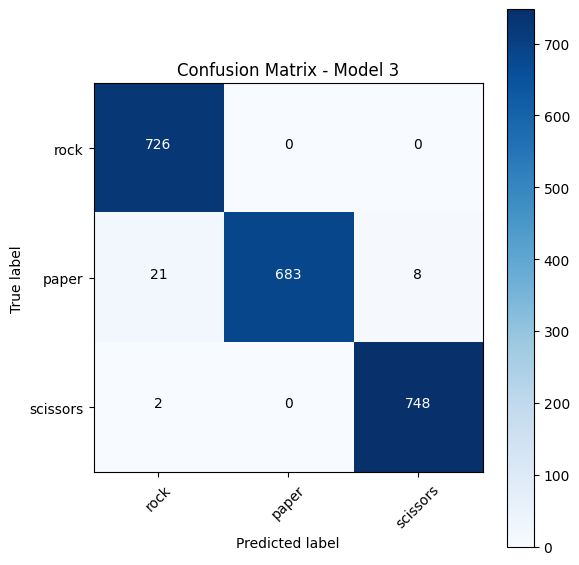

In [18]:
import matplotlib.pyplot as plt
import itertools

# Predictions
y_pred_probs = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Manual confusion matrix
cm = np.zeros((3, 3), dtype=int)
for i in range(len(y_test)):
    cm[y_test[i], y_pred_classes[i]] += 1

# Plot confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Model 3")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Print numbers inside cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [19]:
# Manual precision, recall, f1
def classification_report_manual(y_true, y_pred, class_names):
    report = {}
    for i, cls in enumerate(class_names):
        tp = np.sum((y_true == i) & (y_pred == i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        tn = np.sum((y_true != i) & (y_pred != i))

        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

        report[cls] = {
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1-score": round(f1, 3),
            "support": int(tp + fn)
        }
    return report

report = classification_report_manual(y_test, y_pred_classes, classes)
for cls, metrics in report.items():
    print(f"{cls:10} {metrics}")


rock       {'precision': np.float64(0.969), 'recall': np.float64(1.0), 'f1-score': np.float64(0.984), 'support': 726}
paper      {'precision': np.float64(1.0), 'recall': np.float64(0.959), 'f1-score': np.float64(0.979), 'support': 712}
scissors   {'precision': np.float64(0.989), 'recall': np.float64(0.997), 'f1-score': np.float64(0.993), 'support': 750}


In [20]:
model3.save("rps_cnn_model3.h5")


In [22]:
from tensorflow.keras.optimizers import SGD

# Model 3 with SGD
model3_sgd = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile with SGD
model3_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_sgd = model3_sgd.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.6655 - loss: 1.9832 - val_accuracy: 0.8146 - val_loss: 0.6697
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8586 - loss: 0.5801 - val_accuracy: 0.9176 - val_loss: 0.2397
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9187 - loss: 0.2635 - val_accuracy: 0.9176 - val_loss: 0.2063
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9354 - loss: 0.2189 - val_accuracy: 0.9359 - val_loss: 0.2038
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9638 - loss: 0.1400 - val_accuracy: 0.9428 - val_loss: 0.1228
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9501 - loss: 0.1782 - val_accuracy: 0.9611 - val_loss: 0.1266
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9653 - loss: 0.1338 - val_accuracy: 0.9497 - val_loss: 0.1348
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9746 - loss: 0.0802 - val_accuracy: 0.9817 -

In [24]:
model3_gap = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),  # GAP instead of Flatten
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model3_gap.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_gap = model3_gap.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.7506 - loss: 0.6864 - val_accuracy: 0.3455 - val_loss: 1.9384
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9745 - loss: 0.0812 - val_accuracy: 0.3455 - val_loss: 2.3174
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9830 - loss: 0.0660 - val_accuracy: 0.3455 - val_loss: 3.4750
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9811 - loss: 0.0594 - val_accuracy: 0.5034 - val_loss: 2.2495
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9895 - loss: 0.0334 - val_accuracy: 0.5309 - val_loss: 2.3069
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9977 - loss: 0.0162 - val_accuracy: 0.4211 - val_loss: 2.8348
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9959 - loss: 0.0139 - val_accuracy: 0.7002 - val_loss: 1.9022
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9897 - loss: 0.0303 - val_accuracy: 0.7574 

In [25]:
# Evaluate Model 3 variants on manual test set
print("Evaluating Model 3 (Adam):")
test_loss_adam, test_acc_adam = model3.evaluate(
    X_test, tf.keras.utils.to_categorical(y_test, num_classes=3), verbose=0
)

print("Evaluating Model 3-SGD:")
test_loss_sgd, test_acc_sgd = model3_sgd.evaluate(
    X_test, tf.keras.utils.to_categorical(y_test, num_classes=3), verbose=0
)

print("Evaluating Model 3-GAP (Adam):")
test_loss_gap, test_acc_gap = model3_gap.evaluate(
    X_test, tf.keras.utils.to_categorical(y_test, num_classes=3), verbose=0
)

# Print comparison table
print("\n=== Test Results Comparison ===")
print(f"Model 3 (Adam)     -> Accuracy: {test_acc_adam:.4f}, Loss: {test_loss_adam:.4f}")
print(f"Model 3-SGD        -> Accuracy: {test_acc_sgd:.4f}, Loss: {test_loss_sgd:.4f}")
print(f"Model 3-GAP (Adam) -> Accuracy: {test_acc_gap:.4f}, Loss: {test_loss_gap:.4f}")


Evaluating Model 3 (Adam):
Evaluating Model 3-SGD:
Evaluating Model 3-GAP (Adam):

=== Test Results Comparison ===
Model 3 (Adam)     -> Accuracy: 0.9858, Loss: 0.0937
Model 3-SGD        -> Accuracy: 0.9762, Loss: 0.1487
Model 3-GAP (Adam) -> Accuracy: 0.9511, Loss: 0.1433


In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model("rps_cnn_model3.h5")

# Define the class labels (must match training generator order)
class_labels = ["rock", "paper", "scissors"]

# Universal prediction function
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0  # normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    prediction = model.predict(img_array, verbose=0)
    pred_class = np.argmax(prediction, axis=1)[0]

    # Print results
    probs = {cls: float(f"{p:.4f}") for cls, p in zip(class_labels, prediction[0])}
    print(f"Image: {img_path}")
    print(f"Predicted class: {class_labels[pred_class]}")
    print("Probabilities:", probs)
    print("")

# Test on custom images
predict_image("scissors.jpeg")
predict_image("paper.jpg")


Image: scissors.jpeg
Predicted class: paper
Probabilities: {'rock': 0.0, 'paper': 1.0, 'scissors': 0.0}

Image: paper.jpg
Predicted class: paper
Probabilities: {'rock': 0.0, 'paper': 0.9633, 'scissors': 0.0367}

